# Predicting the Survival of Titanic Passengers

### Step 1:
Preprocess the data. Selection/generation/ transformation of categorical variables, useful variables etc all your discretion.

1. Import necessary libraries and packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

2. Import Titanic_train dataset and explore the dataset

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


3.1. Now, cleanse the dataset: check duplicity 

In [5]:
train.duplicated().sum()

0

3.2. Check missing values and devise different strategies
1) Cabin: 687 null values (77% of the total observations) 
2) Age: Age has 177 null values (20% of the observations)
3) Embarked: 2 null values (0.0022% of the observations)

In [6]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

3.2.1. Drop 'Cabin' column
- It has too large portion of missing values, which is hard to imputue

In [7]:
train = train.drop('Cabin', axis = 1)

In [8]:
'Cabin' in train.columns

False

3.2.2. Interpolate 'Age' column
- The portion of missing values is manageable to be imputed
- However, we want to keep the characteristics from the original data as similar as possible, as shown in .describe()
- Therefore, we will use .interpolate() to impute

<function matplotlib.pyplot.show(close=None, block=None)>

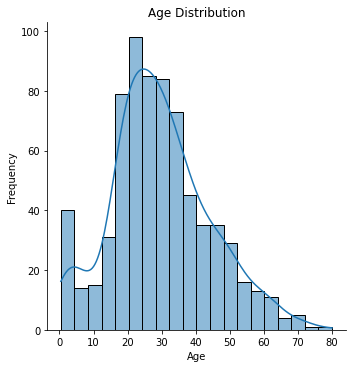

In [9]:
sns.displot(train['Age'], kde=True)

plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.show

In [10]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [11]:
train['Age'] = train['Age'].interpolate()

In [12]:
train['Age'].describe()

count    891.000000
mean      29.726061
std       13.902353
min        0.420000
25%       21.000000
50%       28.500000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

3.2.3. Imptue 'Embarked' column
- It has only two missing values, so replace missing values with the most frequently appearing values(=mode), in this case, 'S'
- This imputation will not influence the original dataset significantly

In [13]:
train['Embarked'].value_counts(ascending = False)

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [14]:
train['Embarked'].fillna('S', inplace = True)

In [15]:
train['Embarked'].value_counts(ascending = False)

S    646
C    168
Q     77
Name: Embarked, dtype: int64

4. Feature Engineering: Drop unnecessary columns 
- We will drop the columns with text data, assuming that they have no predicting power

In [16]:
train = train.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

In [17]:
train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

5. Feature Enginnering: one hot encoding
- categorical variable: Sex, Pclass, Embarked 
- Transform the categorical variables in the dataset through one hot encoding
- Using get_dummies(), now, there are values either 0 or 1 in the categorical variables 

In [18]:
train = pd.get_dummies(train, columns = ['Pclass', 'Embarked'])

In [19]:
train['Sex'].value_counts(ascending = False)

male      577
female    314
Name: Sex, dtype: int64

In [20]:
train['Sex'] = np.where(train['Sex'] == 'male', 0, 1)

In [21]:
train.rename(columns = {'Sex':'Is_female'}, inplace = True)

In [22]:
train.head()

,Survived,Is_female,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,0,22.0,1,0,7.2500,0,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,0,1,0,0
2,1,1,26.0,0,0,7.9250,0,0,1,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,0,1
4,0,0,35.0,0,0,8.0500,0,0,1,0,0,1


5.1. Feature Enginnering: create a new variable, feature: 'Family'

- Sib = Sibilings, Sp = Spouse 
- Parch = # of parents / children aboard the Titanic
- Therfore, we create a new variable as 'Family' by combining these two variables and will drop them to remove duplictiy with the newly created variable

In [23]:
train['Family'] = train['SibSp'] + train['Parch']

In [24]:
train = train.drop(['SibSp', 'Parch'], axis = 1)

5.1. Feature Enginnering: create a new variable, feature: 'is_alone'
- The majority of passengers aboarded alone.
- To see whetehr it was a critical factor for survival, we will newly create 'is_alone' variable 

In [25]:
train['Family'].value_counts(normalize = True)*100

0     60.269360
1     18.069585
2     11.447811
3      3.254770
5      2.469136
4      1.683502
6      1.346801
10     0.785634
7      0.673401
Name: Family, dtype: float64

In [26]:
train['Is_alone'] = np.where(train['Family']==0, 1, 0)

In [27]:
train['Is_alone'].value_counts(ascending = False)

1    537
0    354
Name: Is_alone, dtype: int64

5.1. Feature Enginnering: create a new variable, feature: 'is_child'
- The majority of passengers (75%) were adults with age more than 21
- To see not being an adult is a critical factor for survival, we will newly create a variable 'is_child'
- The threshold is age 15 and around 10% of the passengers were child

In [28]:
train['Age'].describe()

count    891.000000
mean      29.726061
std       13.902353
min        0.420000
25%       21.000000
50%       28.500000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [29]:
train['Is_child'] = np.where(train['Age'] >= 15, 1, 0)

In [30]:
train['Is_child'].value_counts(normalize = True)*100

1    89.786756
0    10.213244
Name: Is_child, dtype: float64

6. Start EDA with the cleansed Titanic train dataset

In [31]:
train.columns

Index(['Survived', 'Is_female', 'Age', 'Fare', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Family',
       'Is_alone', 'Is_child'],
      dtype='object')

6.1. Survival 
- only 38% of the total passenger of Titanic in our train data set survived

/Users/misunsong/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


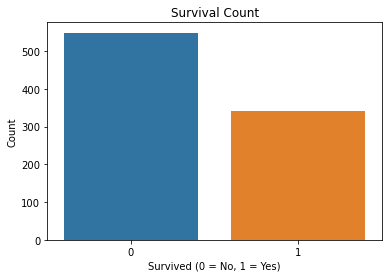

In [32]:
sns.countplot(train['Survived'])

plt.title("Survival Count")
plt.xlabel("Survived (0 = No, 1 = Yes)")
plt.ylabel("Count")

plt.show()

In [33]:
train['Survived'].value_counts(normalize = True)*100

0    61.616162
1    38.383838
Name: Survived, dtype: float64

6.2. Sex and Survival
- Female passengers died less(81) and survived more(233) significantly compared to male passengers

In [34]:
sex = train.groupby(['Is_female', 'Survived']).agg(n = ('Survived', 'count'))
sex

n
Is_female Survived     
0         0         468
          1         109
1         0          81
          1         233

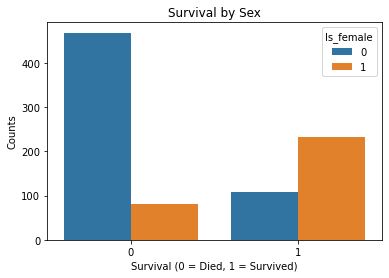

In [35]:
sns.barplot(x = 'Survived', y = 'n', hue = 'Is_female',
            data = sex.reset_index())
    
plt.title('Survival by Sex')
plt.xlabel('Survival (0 = Died, 1 = Survived)')
plt.ylabel('Counts')

plt.show()

6.3. Pc_Class and Survival
- The passengers categorized in a higher Pclass(1) survived more than died.
- Pclass(2) has similar number of passengers who died and survived.
- However, Pclass(3) died more than survied.

In [36]:
pclass = train[['Pclass_1', 'Pclass_2', 'Pclass_3', 'Survived']]

In [37]:
pivot_pclass = pclass.pivot_table(index = 'Survived',
                                     values=['Pclass_1', 'Pclass_2', 'Pclass_3', 'Survived'],
                                     aggfunc = 'sum')

In [38]:
pivot_pclass

,Pclass_1,Pclass_2,Pclass_3
Survived,,,
0,80,97,372.0
1,136,87,119.0


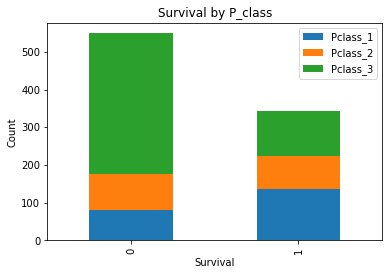

In [39]:
pivot_pclass.plot(kind = 'bar', stacked = True)

plt.title('Survival by P_class')
plt.xlabel('Survival')
plt.ylabel('Count')

plt.show()

6.4. Emarked on Survival
- Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)
- It seems irrelvant to survival, except embarkation at Southampton. People died more when they embarked at Southampton

In [40]:
embarked = train[['Embarked_C', 'Embarked_Q', 'Embarked_S', 'Survived']]
pivot_embarked = embarked.pivot_table(index = 'Survived',
                                     values=['Embarked_C', 'Embarked_Q', 'Embarked_S', 'Survived'],
                                     aggfunc = 'sum')
pivot_embarked

,Embarked_C,Embarked_Q,Embarked_S
Survived,,,
0,75,47,427.0
1,93,30,219.0


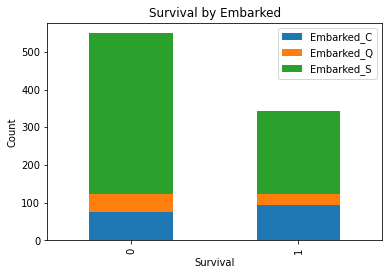

In [41]:
pivot_embarked.plot(kind = 'bar', stacked = True)

plt.title('Survival by Embarked')
plt.xlabel('Survival')
plt.ylabel('Count')

plt.show()

6.5. Being Alone on Survival
- If one passenger aboarded alone, it was more likely to die than survive

In [42]:
is_alone = train.groupby(['Is_alone', 'Survived']).agg(n = ('Survived', 'count'))
is_alone

n
Is_alone Survived     
0        0         175
         1         179
1        0         374
         1         163

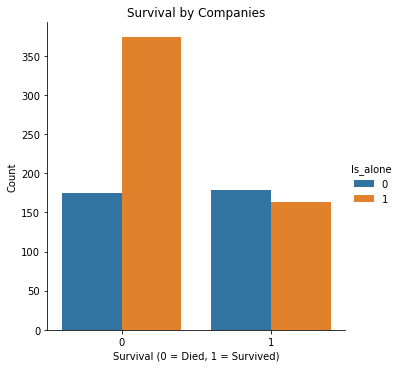

In [43]:
sns.catplot(x = 'Survived', y = 'n', hue = 'Is_alone',
           kind = 'bar', data = is_alone.reset_index())

plt.title('Survival by Companies')
plt.xlabel('Survival (0 = Died, 1 = Survived)')
plt.ylabel('Count')

plt.show()

6.6. Check Cross-relationship betwwen features
- The most critical features for survival from the previous EDA turned out 'Is_female' and 'Pclass(1, 2 or 3)'
- Therefore, we create a crosstab using these two features and see their relationshop with survival
- The plot indicates that the female passenger of Titanic in  Pclass 1 were significantly more likely to survive, compared to the male passneger, and espeically male passenter in Plcass 3.

In [44]:
train_add = pd.read_csv('train.csv')

In [45]:
pd.crosstab([train_add.Sex, train_add.Survived], train_add.Pclass, margins=True)
# https://www.kaggle.com/code/melodyyiphoiching/titanic-survival-prediction-ml

Pclass             1    2    3  All
Sex    Survived                    
female 0           3    6   72   81
       1          91   70   72  233
male   0          77   91  300  468
       1          45   17   47  109
All              216  184  491  891

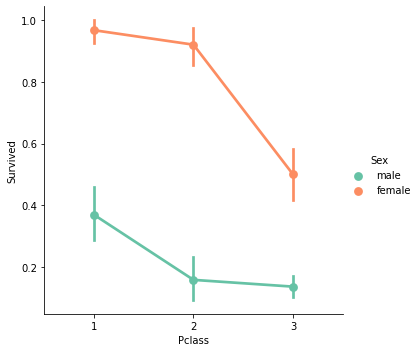

In [46]:
import warnings
warnings.filterwarnings("ignore")

sns.factorplot('Pclass','Survived',hue='Sex',data=train_add, palette='Set2')
plt.show()

- The heatmap shows similar aspects
- Gender: Female, Pclass: 1, Fare(related to Pcalss1) have relatively strong relationship with survival(1) from Titanic tragedy

Text(0.5, 1.0, 'Features Correlating with Survived')

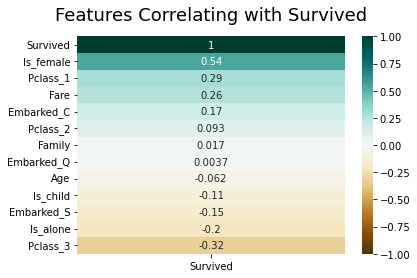

In [47]:
heatmap = sns.heatmap(train.corr()[['Survived']].sort_values(by='Survived', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Survived', fontdict={'fontsize':18}, pad=16)

# https://medium.com/@melodyyip515_/titanic-survival-prediction-using-machine-learning-89a779656113

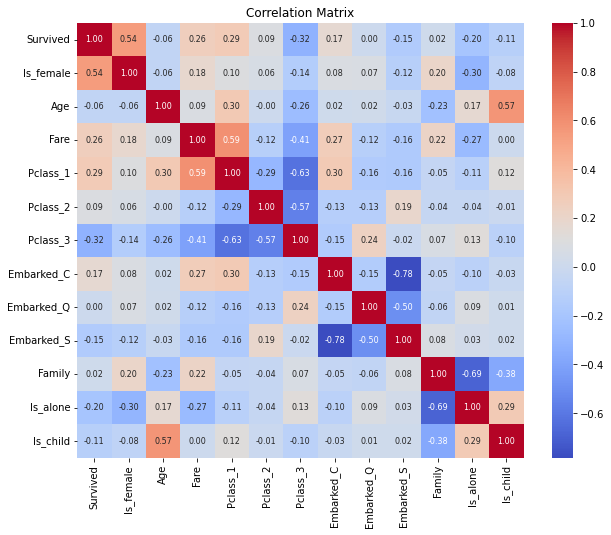

In [48]:
corr = train.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f', annot_kws={'size': 8})

plt.title("Correlation Matrix")
plt.show()

### Step 2:
Build your models: Please build classification models in Python to predict the Survived binary status assigned to a passenger. When writing the code associated with each model, please have the first part produce and save the model, followed by a second part that loads and applies the model.

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier

In [50]:
X = train.drop('Survived', axis = 1).copy()
y = train['Survived'].copy()

In [51]:
# split the data into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
import warnings
warnings.filterwarnings("ignore")
import pickle

models = [LogisticRegression, SVC, LinearSVC, KNeighborsClassifier, DecisionTreeClassifier, RandomForestClassifier, GaussianNB, Perceptron, SGDClassifier]
model_names = ['Logistic_Regression', 'Support_Vector_Machines', 'Linear_SVC', 
              'KNN', 'Decision_Tree', 'Random_Forest', 'Naive_Bayes', 
              'Perceptron', 'Stochastic_Gradient_Decent']
scores = []

for i, model in enumerate(models):
    classifier = model()
    classifier.fit(train_X, train_y)
    acc = round(classifier.score(test_X, test_y)*100, 2)
    scores.append(acc)
    
    filename = 'model_' + model_names[i] + '.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(classifier, file)
    
table = pd.DataFrame({'Model': model_names, 'Score': scores}).sort_values(by='Score', ascending=False)

In [53]:
table

,Model,Score
5,Random_Forest,83.80
0,Logistic_Regression,81.56
4,Decision_Tree,79.33
6,Naive_Bayes,76.54
8,Stochastic_Gradient_Decent,73.74
3,KNN,71.51
1,Support_Vector_Machines,65.92
7,Perceptron,58.66
2,Linear_SVC,53.07


### Step 3:
Test your models using the data found within the "Holdout_testing" file. Save the results of the final model (remember you will only predict the Survived column in holdout test set with your best model results) in a single, separate CSV titled "Titanic Results from" *insert your name or UChicago net ID.

1. Prepare testing data set by applying the same feature engineering as training data set

In [54]:
test = pd.read_csv('holdout_test.csv')

In [55]:
test = test.drop('Cabin', axis = 1)
test['Age'] = test['Age'].interpolate()
test['Embarked'].fillna('S', inplace = True)
test = test.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
test['Sex'] = np.where(test['Sex'] == 'male', 0, 1)
test.rename(columns = {'Sex':'Is_female'}, inplace = True)
test = pd.get_dummies(test, columns = ['Pclass', 'Embarked'])
test['Family'] = test['SibSp'] + test['Parch']
test = test.drop(['SibSp', 'Parch'], axis = 1)
test['Is_alone'] = np.where(test['Family']==0, 1, 0)
test['Is_child'] = np.where(test['Age'] >= 15, 1, 0)

In [56]:
print(train.shape)
print(test.shape)

(891, 13)
(418, 13)


In [57]:
print(train.columns)
print(test.columns)

Index(['Survived', 'Is_female', 'Age', 'Fare', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Family',
       'Is_alone', 'Is_child'],
      dtype='object')
Index(['Survived', 'Is_female', 'Age', 'Fare', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Family',
       'Is_alone', 'Is_child'],
      dtype='object')


2. Found one null value in 'Fare' so filled it with the feature's mean

In [58]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    0 non-null      float64
 1   Is_female   418 non-null    int64  
 2   Age         418 non-null    float64
 3   Fare        417 non-null    float64
 4   Pclass_1    418 non-null    uint8  
 5   Pclass_2    418 non-null    uint8  
 6   Pclass_3    418 non-null    uint8  
 7   Embarked_C  418 non-null    uint8  
 8   Embarked_Q  418 non-null    uint8  
 9   Embarked_S  418 non-null    uint8  
 10  Family      418 non-null    int64  
 11  Is_alone    418 non-null    int64  
 12  Is_child    418 non-null    int64  
dtypes: float64(3), int64(4), uint8(6)
memory usage: 25.4 KB


In [59]:
test['Fare'] = test['Fare'].fillna(test['Fare'].mean())

3. Remove 'Survived' feature because we will predict the feature with the model built previously 

In [60]:
holdout_test_X = test.drop('Survived', axis = 1)

In [61]:
holdout_test_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Is_female   418 non-null    int64  
 1   Age         418 non-null    float64
 2   Fare        418 non-null    float64
 3   Pclass_1    418 non-null    uint8  
 4   Pclass_2    418 non-null    uint8  
 5   Pclass_3    418 non-null    uint8  
 6   Embarked_C  418 non-null    uint8  
 7   Embarked_Q  418 non-null    uint8  
 8   Embarked_S  418 non-null    uint8  
 9   Family      418 non-null    int64  
 10  Is_alone    418 non-null    int64  
 11  Is_child    418 non-null    int64  
dtypes: float64(2), int64(4), uint8(6)
memory usage: 22.2 KB


1. Choose 'Random_Forest' to predict 

In [62]:
model_names = ['Logistic_Regression', 'Support_Vector_Machines', 'Linear_SVC', 
              'KNN', 'Decision_Tree', 'Random_Forest', 'Naive_Bayes', 
              'Perceptron', 'Stochastic_Gradient_Decent']

filename = 'model_' + 'Random_Forest' + '.pkl'
loaded_model = pickle.load(open(filename, 'rb'))

2. Predict whether 'Survived' or not having the feature in the data set 'holdout_test_X' and save it

In [63]:
predictions = loaded_model.predict(holdout_test_X)
predictions_df = pd.DataFrame({'Prediction': predictions})

In [64]:
predictions_df.to_csv('Titanic Results.csv', index = False)